In [1]:
#!pip install torch
#!pip install fastai --upgrade -q
#!pip install optuna scikit-learn-intelex torcheval

In [1]:
#Hacer que sklearn funciones con la GPU
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import fastai.tabular.all as ft
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,  f1_score, mean_absolute_error, mean_squared_error, precision_score, r2_score, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR, SVC
import torch
import torcheval.metrics.functional as mF
import torch.nn as nn
import torch.nn.functional as F
import warnings

In [3]:
gc.collect()

0

In [4]:
warnings.filterwarnings('ignore')

# Carga de datos

In [5]:
data_path = "./data"

In [6]:
otus = pd.read_csv(f"{data_path}/metadata_agave_clavi_solena - metadata.csv", index_col=0)
otus

,Experiment,Assay Type,seq_type,Organism,plant_part,host_name,latitude,longitude,state,country,continent
sample_id,,,,,,,,,,,
SRR10127267,SRX6855687,WGS,Shotgun,plant metagenome,Phylosphere,Agave Tequilana,21.765800,-100.163000,Jalisco,Mexico,North America
SRR10127271,SRX6855691,WGS,Shotgun,plant metagenome,Phylosphere,Myrtillocactus Geometrizans,21.765800,-100.163000,Guanajuato,Mexico,North America
SRR10591223,SRX7271075,WGA,16S,rhizosphere metagenome,Rhizosphere,Cephalocereus polylophus,20.590000,-100.380000,Queretaro,Mexico,North America
SRR10591224,SRX7271074,WGA,16S,rhizosphere metagenome,Rhizosphere,Cephalocereus polylophus,20.590000,-100.380000,Queretaro,Mexico,North America
SRR10591225,SRX7271073,WGA,16S,rhizosphere metagenome,Rhizosphere,Cephalocereus polylophus,20.590000,-100.380000,Queretaro,Mexico,North America
...,...,...,...,...,...,...,...,...,...,...,...
t-AYtCM2TOMPOOA100360,NaN,NaN,NaN,NaN,NaN,Solanum lycopersicum,21.019015,-101.257359,Guanajuato,Mexico,North America
t-DYZgM2TOMPOOB100370,NaN,NaN,NaN,NaN,NaN,Solanum lycopersicum,21.019015,-101.257359,Guanajuato,Mexico,North America
t-eBCjM2CHIPOOBXX1180,NaN,NaN,NaN,NaN,NaN,Capsicum,25.172109,-107.479517,Sinaloa,Mexico,North America


# Evaluadores y más

In [7]:
def objective_clas(trial):
    """
    Lo primero a optimizar son las capas de las redes, para
    decidir cuántas capas y cuántas neuronas hay en cada una,
    lo que haremos será sugerir un valor para el total de capas
    y posteriormente crearemos una lista con sugerencias de optuna
    para la cantidad de neuronas por capa
    """

    nl = trial.suggest_int("n_layers", 1,13)
    layers =  [trial.suggest_int("n_neuronas_layer"+str(i), 32, 256) for i in range(nl)]

    #print(f"Caps de neuronas:{layers}")

    """
    Dentro de las opciones para configurar el modelo del learner nos
    encontramos con bn_final y embed_p, anteriormente estos parámetros
    fueron de ayuda en la tarea pasada, por lo que vamos a ver la 
    sugerencia de optuna
    """
    bnFinal = trial.suggest_categorical("bn_final", [True, False])
    embedP = trial.suggest_float("embed_p",0.01,1)
    
    """
    También vamos a buscar la función de activación más adecuada 
    para este caso. Dado que optuna no nos permite elegir un elemento
    de una lista de funciones, lo que haremos será crear una lista de 
    funciones y dejaremos que optuna elija el índice de esta lista, así
    va a elegir de manera indirecta la función de activación adecuada.
    """
    actClsList = [nn.ReLU(inplace=True),nn.LeakyReLU(inplace=True), nn.CELU(inplace=True)]
    idxActCls = trial.suggest_int("idx_act_cls",0,2)
    actCls= actClsList[idxActCls]

    """
    También podemos dejar que optuna elija el optimizador por nosootros,
    y lo haremos de la misma forma en la que se elige la función de 
    activación.
    """
    optimList = [ft.ranger, ft.Adam]
    idxOptim = trial.suggest_int('idx_opt_func',0,1)
    optim = optimList[idxOptim]

    #Creamos el learner
    learn = ft.tabular_learner(dls,
                                layers = layers,
                               loss_func= ft.CrossEntropyLossFlat(),
                                config =ft.tabular_config(
                                    act_cls=actCls, 
                                    embed_p=embedP, 
                                    bn_final=bnFinal),
                                opt_func=optim,
                                metrics=[ft.accuracy, ft.Recall(average="weighted"), ft.Precision(average="weighted"), ft.F1Score(average="weighted")],
                               )

    
    """
    Para el entrenamiento del learner vamos a optimizar el
    número de épocas, la tasa de aprendizaje, el pct_start, div_final
    y el valor de div
    """

    epoch = trial.suggest_int("epoch",23,250)
    lr = trial.suggest_float("lr",1e-6,1e-1)
    pctStart = trial.suggest_float("pct_start",0.01,0.9)
    divFinal = trial.suggest_int("div_final",int(1e2),int(1e6))
    div = trial.suggest_float("div",0.01,1)
    

    #Entrenamos el learner con lo obtenido
    learn.fit_one_cycle(epoch, lr, pct_start=pctStart, 
                        div_final=divFinal, div=div
                        )
    
    #Regresamos el error promedio del entrenamiento
    return 1-learn.recorder.metrics[0].value.item()

In [8]:
def eval_cv_clas(cv, metodo):
    """
    EVALUA EL DESEMPENIO PROMEDIO AL HACER VALIDACION CRUZADA
    """
    return {metodo : [np.mean(cv["test_accuracy"]), np.mean(cv["test_recall_weighted"]), np.mean(cv["test_precision_weighted"]), np.mean(cv["test_f1_weighted"])]}

In [9]:
def eval_pred_clas(y_test, y_pred, metodo):
    """
    EVALUA LA PREDICCION CLASIFICADA
    """
    return {metodo:[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average="weighted"), precision_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]}

# Ciudad

### Con RN

In [11]:
# Definicion de variables
cat_names = []
cont_names = list(otus.drop(["state"], axis=1).columns)

In [12]:
y_names = ["state"]

In [13]:
# Filtrado de datos, solo aquellos que tengan internet
train_df = otus[cat_names+cont_names+y_names]
train_df

,469,28090,2853158,2545797,1808001,2798861,1636603,2053287,108981,70346,...,332999,28454,2675878,2057025,28132,9606,28449,2789425,1613,Ciudad
CAMDA23_MetaSUB_gCSD16_AKL_10,0.124256,0.180126,0.021423,0.000589,0.000562,0.000479,0.000341,0.024284,0.004159,0.003476,...,0.000039,0.000045,0.000010,0.000012,0.000003,0.002052,0.000000e+00,0.000000e+00,0.000000,AKL
CAMDA23_MetaSUB_gCSD16_AKL_11,0.005518,0.000497,0.000083,0.000012,0.000323,0.000476,0.000004,0.000081,0.000650,0.000228,...,0.020769,0.000074,0.000011,0.000091,0.000021,0.002978,0.000000e+00,0.000000e+00,0.000000,AKL
CAMDA23_MetaSUB_gCSD16_AKL_12,0.002191,0.000552,0.000036,0.000008,0.000011,0.000055,0.000013,0.000044,0.000172,0.000095,...,0.000035,0.000003,0.000470,0.000720,0.010626,0.088311,3.652450e-04,1.942126e-05,0.000004,AKL
CAMDA23_MetaSUB_gCSD16_AKL_13,0.000143,0.000116,0.000009,0.000002,0.000003,0.000024,0.000002,0.000012,0.000043,0.000023,...,0.005426,0.000095,0.000011,0.000011,0.000017,0.001826,2.947903e-07,0.000000e+00,0.000000,AKL
CAMDA23_MetaSUB_gCSD16_AKL_14,0.000628,0.000824,0.000012,0.000001,0.000004,0.000018,0.000003,0.000021,0.000052,0.000021,...,0.000263,0.000066,0.000014,0.000028,0.000017,0.001130,3.709748e-07,3.709748e-07,0.000000,AKL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMDA23_MetaSUB_gCSD17_ZRH_16,0.002291,0.000161,0.000007,0.000015,0.000013,0.000050,0.000018,0.000018,0.000520,0.000154,...,0.000002,0.000056,0.000031,0.000011,0.000726,0.431000,1.792369e-04,7.565513e-04,0.000080,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_1,0.002829,0.001188,0.000017,0.000015,0.000012,0.000015,0.000024,0.000024,0.000291,0.000270,...,0.000003,0.000022,0.000032,0.000015,0.000226,0.723183,6.875735e-05,2.188776e-04,0.000020,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_3,0.003510,0.001876,0.000020,0.000004,0.000017,0.000043,0.000009,0.000042,0.001327,0.000064,...,0.000008,0.000035,0.000117,0.000025,0.000170,0.331686,3.780614e-05,2.533576e-04,0.000023,ZRH
CAMDA23_MetaSUB_gCSD17_ZRH_4,0.003401,0.001387,0.000017,0.000005,0.000011,0.000018,0.000010,0.000023,0.001141,0.000050,...,0.000002,0.000025,0.000039,0.000015,0.000155,0.436214,3.724220e-05,2.196913e-04,0.000011,ZRH


In [14]:
train_df[y_names].value_counts()

Ciudad
DEN       38
DOH       22
ILR       20
TOK       19
SAO       18
LIS       15
SAN       15
AKL       14
NYC       14
SAC       14
BAL       10
ZRH        9
VIE        8
BER        6
BOG        4
MIN        4
dtype: int64

In [15]:
y = np.array(train_df[y_names]).ravel()
X = np.array(train_df.drop(y_names,axis=1)).astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=18)

In [16]:
train_df = pd.DataFrame(data=X_train, columns=train_df.drop(y_names, axis=1).columns)
train_df[y_names[0]] = y_train
train_df[y_names[0]] = train_df[y_names[0]].astype("category")

In [17]:
train_df[y_names].value_counts()

Ciudad
DEN       32
DOH       20
ILR       18
TOK       17
LIS       15
SAN       15
SAO       15
NYC       14
AKL       11
SAC       11
BAL        9
VIE        8
ZRH        8
BER        6
BOG        4
MIN        4
dtype: int64

In [18]:
dls = ft.TabularDataLoaders.from_df(train_df,
                       procs=[ft.Categorify, ft.FillMissing],
                       cat_names = cat_names,
                       cont_names = cont_names,
                       y_names = y_names,
                       val_shuffle =True,
                       shuffle=True,
                       bs=128,
                       )

In [19]:
learn = ft.tabular_learner(dls,
                           layers = [512, 128, 128, 256, 128],
                           loss_func = ft.CrossEntropyLossFlat(),
                           config = ft.tabular_config(act_cls=nn.ReLU(inplace=True), bn_final=True, embed_p=0.15),
                           opt_func=ft.ranger,
                           metrics=[ft.accuracy,ft.Recall(average="macro"), ft.Precision(average="macro"), ft.F1Score(average="macro")])

SuggestedLRs(valley=0.0030199517495930195)

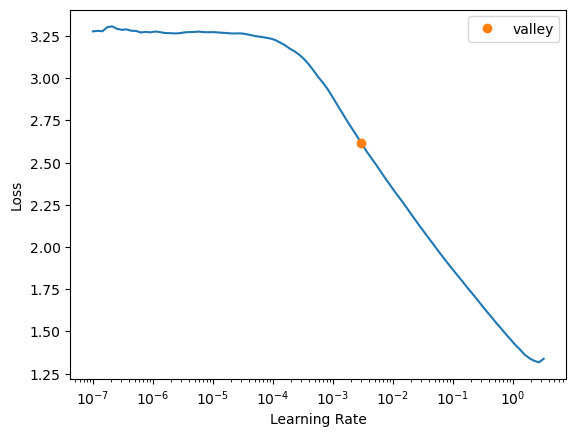

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(1000,0.002, pct_start=0.23, div_final = 100000, div=0.87)

epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,time
0,3.208584,2.770725,0.073171,0.062500,0.004573,0.008523,00:00
1,3.146387,2.768478,0.073171,0.062500,0.004573,0.008523,00:00
2,3.043165,2.766201,0.073171,0.062500,0.004573,0.008523,00:00
3,2.983090,2.764325,0.073171,0.062500,0.004573,0.008523,00:00
4,2.889501,2.762261,0.073171,0.062500,0.004573,0.008523,00:00
5,2.822925,2.760375,0.073171,0.062500,0.004573,0.008523,00:00
6,2.785226,2.758271,0.073171,0.062500,0.004573,0.008523,00:00
7,2.708845,2.756294,0.073171,0.062500,0.004573,0.008523,00:00
8,2.603368,2.754614,0.073171,0.062500,0.004573,0.008523,00:00
9,2.496706,2.753075,0.073171,0.062500,0.004573,0.008523,00:00


In [22]:
learn.save('learner_ciudad')

Path('models/learner_ciudad.pth')

In [23]:
dl = learn.dls.test_dl(pd.DataFrame(data=X_test, columns=train_df.drop(y_names,axis=1).columns), bs=128) # apply transforms
preds,  y = learn.get_preds(dl=dl) # get prediction

In [24]:
y_predrn = np.array([dl.vocab[list(probs).index(max(probs))] for probs in preds])

In [25]:
resultados_rn = eval_pred_clas(y_predrn,y_test, "RN")
resultados_rn

{'RN': [0.5652173913043478,
  0.5652173913043478,
  0.6014492753623188,
  0.5706004140786749]}

### Con SVM

In [26]:
svm = SVC(C=1.0)

In [27]:
svm_cv = cross_validate(svm, X_train, y_train, cv=10, scoring=["accuracy","recall_weighted", "precision_weighted", "f1_weighted" ])
svm_cv

{'fit_time': array([0.01193595, 0.00768924, 0.00838876, 0.00811052, 0.00750852,
        0.00816154, 0.00776887, 0.00800705, 0.00799632, 0.00800061]),
 'score_time': array([0.01170039, 0.01128221, 0.01251173, 0.00927997, 0.01082683,
        0.01270556, 0.00999713, 0.01399851, 0.0088675 , 0.01284385]),
 'test_accuracy': array([0.28571429, 0.23809524, 0.38095238, 0.33333333, 0.42857143,
        0.23809524, 0.38095238, 0.3       , 0.3       , 0.3       ]),
 'test_recall_weighted': array([0.28571429, 0.23809524, 0.38095238, 0.33333333, 0.42857143,
        0.23809524, 0.38095238, 0.3       , 0.3       , 0.3       ]),
 'test_precision_weighted': array([0.14965986, 0.0984127 , 0.24761905, 0.20952381, 0.38492063,
        0.10582011, 0.34249084, 0.17424242, 0.175     , 0.13560606]),
 'test_f1_weighted': array([0.17989418, 0.12781955, 0.26321298, 0.22466422, 0.35555556,
        0.13636364, 0.30753968, 0.20428571, 0.20666667, 0.18119048])}

In [28]:
cv_svm = eval_cv_clas(svm_cv, "SVM")
cv_svm

{'SVM': [0.3185714285714285,
  0.3185714285714285,
  0.20232954875812018,
  0.21871926625310084]}

In [29]:
svm.fit(X_train,y_train)

SVC()

In [30]:
y_test_pred = svm.predict(X_test)

In [31]:
resultados_svm = eval_pred_clas(y_test,y_test_pred, "SVM")
resultados_svm

{'SVM': [0.34782608695652173,
  0.34782608695652173,
  0.15527950310559005,
  0.21449275362318837]}

### Con N-vecinos

In [32]:
nc = KNeighborsClassifier(n_neighbors=6, weights='distance')

In [33]:
nc_cv = cross_validate(nc, X_train, y_train, cv=10,  scoring=["accuracy","recall_weighted", "precision_weighted", "f1_weighted" ])
nc_cv

{'fit_time': array([0.00500059, 0.00199986, 0.00199914, 0.00200725, 0.00200796,
        0.00203443, 0.00200081, 0.00200725, 0.00200009, 0.00100088]),
 'score_time': array([0.00799918, 0.00600028, 0.00600004, 0.00513816, 0.00611472,
        0.00592518, 0.00600505, 0.005584  , 0.00301051, 0.00399494]),
 'test_accuracy': array([0.33333333, 0.23809524, 0.28571429, 0.19047619, 0.14285714,
        0.19047619, 0.28571429, 0.1       , 0.25      , 0.4       ]),
 'test_recall_weighted': array([0.33333333, 0.23809524, 0.28571429, 0.19047619, 0.14285714,
        0.19047619, 0.28571429, 0.1       , 0.25      , 0.4       ]),
 'test_precision_weighted': array([0.2452381 , 0.23015873, 0.19047619, 0.12222222, 0.15      ,
        0.16780045, 0.25510204, 0.05714286, 0.175     , 0.41666667]),
 'test_f1_weighted': array([0.27301587, 0.21428571, 0.21269841, 0.14693878, 0.13151927,
        0.15873016, 0.24761905, 0.0625    , 0.19619048, 0.36666667])}

In [34]:
cv_nc = eval_cv_clas(nc_cv, "NC")
cv_nc

{'NC': [0.24166666666666664,
  0.24166666666666664,
  0.20098072562358277,
  0.20101643990929707]}

In [35]:
nc.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, weights='distance')

In [36]:
y_test_prednn = nc.predict(X_test)

In [37]:
resultados_nc = eval_pred_clas(y_test,y_test_prednn, "CV")
resultados_nc

{'CV': [0.43478260869565216,
  0.43478260869565216,
  0.3927536231884058,
  0.3840579710144928]}

### Random Forest

In [38]:
rf = RandomForestClassifier(random_state=18)

In [39]:
rf_cv = cross_validate(rf, X_train, y_train, cv=10, scoring=["accuracy","recall_weighted", "precision_weighted", "f1_weighted" ])
rf_cv

{'fit_time': array([0.12118077, 0.13887906, 0.13167667, 0.11841893, 0.11852527,
        0.12185049, 0.13567781, 0.1268785 , 0.11458302, 0.11088395]),
 'score_time': array([0.00493479, 0.00641179, 0.00702715, 0.00666142, 0.00399947,
        0.00499511, 0.00599241, 0.00499964, 0.00300956, 0.00499797]),
 'test_accuracy': array([0.66666667, 0.71428571, 0.80952381, 0.61904762, 0.57142857,
        0.80952381, 0.76190476, 0.8       , 0.75      , 0.75      ]),
 'test_recall_weighted': array([0.66666667, 0.71428571, 0.80952381, 0.61904762, 0.57142857,
        0.80952381, 0.76190476, 0.8       , 0.75      , 0.75      ]),
 'test_precision_weighted': array([0.5952381 , 0.56122449, 0.8015873 , 0.57142857, 0.48412698,
        0.81349206, 0.79931973, 0.75      , 0.73166667, 0.6875    ]),
 'test_f1_weighted': array([0.62222222, 0.61471861, 0.79047619, 0.57142857, 0.5015873 ,
        0.78594104, 0.73650794, 0.76666667, 0.70916667, 0.71190476])}

In [40]:
cv_rf = eval_cv_clas(rf_cv, "RF")
cv_rf

{'RF': [0.7252380952380952,
  0.7252380952380952,
  0.6795583900226757,
  0.6810619975262833]}

In [41]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=18)

In [42]:
y_test_predrf = rf.predict(X_test)

In [43]:
resultados_rf = eval_pred_clas(y_test, y_test_predrf, "RF")
resultados_rf

{'RF': [0.9565217391304348,
  0.9565217391304348,
  0.9192546583850931,
  0.9364548494983278]}

### Ensamble

#### Votacion

In [44]:
vot = VotingClassifier(
    estimators=[('svm', clone(svm)), ('rf', clone(rf)), ('nc', clone(nc))]
)

In [45]:
vot_cv = cross_validate(vot, X_train, y_train, cv=10, scoring=["accuracy","recall_weighted", "precision_weighted", "f1_weighted" ])
vot_cv

{'fit_time': array([0.09366083, 0.09057188, 0.09973764, 0.10360622, 0.13078594,
        0.09974408, 0.10521078, 0.11351633, 0.09831285, 0.09198833]),
 'score_time': array([0.00900078, 0.00799966, 0.01100111, 0.01079607, 0.01301003,
        0.00899982, 0.01036525, 0.00999999, 0.00899935, 0.0080061 ]),
 'test_accuracy': array([0.33333333, 0.42857143, 0.52380952, 0.42857143, 0.42857143,
        0.33333333, 0.42857143, 0.45      , 0.4       , 0.55      ]),
 'test_recall_weighted': array([0.33333333, 0.42857143, 0.52380952, 0.42857143, 0.42857143,
        0.33333333, 0.42857143, 0.45      , 0.4       , 0.55      ]),
 'test_precision_weighted': array([0.15873016, 0.38571429, 0.42063492, 0.37738095, 0.32467532,
        0.25765306, 0.3961039 , 0.32678571, 0.25757576, 0.42      ]),
 'test_f1_weighted': array([0.20634921, 0.36281179, 0.44126984, 0.35456607, 0.33106576,
        0.25781626, 0.36281179, 0.34333333, 0.28928571, 0.4525641 ])}

In [46]:
cv_vot = eval_cv_clas(vot_cv,"Voting")
cv_vot

{'Voting': [0.43047619047619046,
  0.43047619047619046,
  0.33252540713255,
  0.3401873866873867]}

In [47]:
vot.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC()),
                             ('rf', RandomForestClassifier(random_state=18)),
                             ('nc',
                              KNeighborsClassifier(n_neighbors=6,
                                                   weights='distance'))])

In [48]:
y_test_predvot = vot.predict(X_test)

In [49]:
resultados_vot = eval_pred_clas(y_test, y_test_predvot, "Voting")
resultados_vot

{'Voting': [0.6521739130434783,
  0.6521739130434783,
  0.5579710144927535,
  0.5652173913043478]}

#### Bagging

In [50]:
bag = BaggingClassifier(
    base_estimator=clone(rf)
)

In [51]:
bag_cv = cross_validate(bag, X_train, y_train, cv=10, scoring=["accuracy","recall_weighted", "precision_weighted", "f1_weighted" ])
bag_cv

{'fit_time': array([0.87714052, 0.90507698, 0.8605783 , 0.87958741, 0.86440086,
        0.8412168 , 0.89302444, 0.82147264, 0.87944889, 0.83322024]),
 'score_time': array([0.01499987, 0.01299334, 0.01499462, 0.01300502, 0.01300216,
        0.01299977, 0.01307726, 0.00800014, 0.01339149, 0.01806974]),
 'test_accuracy': array([0.61904762, 0.66666667, 0.80952381, 0.57142857, 0.61904762,
        0.76190476, 0.61904762, 0.8       , 0.75      , 0.65      ]),
 'test_recall_weighted': array([0.61904762, 0.66666667, 0.80952381, 0.57142857, 0.61904762,
        0.76190476, 0.61904762, 0.8       , 0.75      , 0.65      ]),
 'test_precision_weighted': array([0.53968254, 0.5       , 0.80952381, 0.42698413, 0.57936508,
        0.77380952, 0.5218254 , 0.79166667, 0.71666667, 0.55833333]),
 'test_f1_weighted': array([0.55396825, 0.56190476, 0.79365079, 0.46428571, 0.56507937,
        0.7446712 , 0.53506494, 0.775     , 0.69666667, 0.58333333])}

In [52]:
cv_bag = eval_cv_clas(bag_cv, "Bagging")
cv_bag

{'Bagging': [0.6866666666666668,
  0.6866666666666668,
  0.6217857142857144,
  0.6273625025767882]}

In [53]:
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(random_state=18))

In [54]:
y_test_predbag = bag.predict(X_test)

In [55]:
resultados_bag = eval_pred_clas(y_test_predbag, y_test, "Bagging")
resultados_bag

{'Bagging': [0.8695652173913043,
  0.8695652173913043,
  0.9130434782608695,
  0.8737060041407869]}

#### Boost

In [56]:
boost = AdaBoostClassifier(clone(rf)
)

In [57]:
boost_cv = cross_validate(boost, X_train, y_train, cv=10, scoring=["accuracy","recall_weighted", "precision_weighted", "f1_weighted" ])
boost_cv

{'fit_time': array([0.13883471, 0.13038802, 0.15257764, 0.15581751, 0.16588211,
        0.15997267, 0.17127037, 0.14771342, 0.16088963, 0.13105297]),
 'score_time': array([0.00551486, 0.00300074, 0.00743055, 0.00300097, 0.00600672,
        0.00400805, 0.00699902, 0.00706267, 0.00700021, 0.0058763 ]),
 'test_accuracy': array([0.66666667, 0.66666667, 0.76190476, 0.61904762, 0.61904762,
        0.80952381, 0.80952381, 0.8       , 0.8       , 0.85      ]),
 'test_recall_weighted': array([0.66666667, 0.66666667, 0.76190476, 0.61904762, 0.61904762,
        0.80952381, 0.80952381, 0.8       , 0.8       , 0.85      ]),
 'test_precision_weighted': array([0.53174603, 0.5       , 0.76190476, 0.55555556, 0.57936508,
        0.81349206, 0.83333333, 0.79166667, 0.78166667, 0.80416667]),
 'test_f1_weighted': array([0.58095238, 0.55555556, 0.74603175, 0.54444444, 0.58321995,
        0.78594104, 0.79365079, 0.775     , 0.75916667, 0.80857143])}

In [58]:
cv_boost = eval_cv_clas(boost_cv, "Boost")
cv_boost

{'Boost': [0.7402380952380951,
  0.7402380952380951,
  0.6952896825396825,
  0.6932534013605443]}

In [59]:
boost.fit(X_train, y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(random_state=18))

In [60]:
y_test_predboost = boost.predict(X_test)

In [61]:
resultados_boost = eval_pred_clas(y_test_predboost,y_test, "Boost")
resultados_boost

{'Boost': [0.782608695652174,
  0.782608695652174,
  0.8260869565217391,
  0.8026755852842808]}

## Resultados

### Cross Validation

In [62]:
cv = dict()
cv.update(cv_svm)
cv.update(cv_nc)
cv.update(cv_rf)
cv.update(cv_vot)
cv.update(cv_vot)
cv.update(cv_bag)
cv.update(cv_boost)
cv

{'SVM': [0.3185714285714285,
  0.3185714285714285,
  0.20232954875812018,
  0.21871926625310084],
 'NC': [0.24166666666666664,
  0.24166666666666664,
  0.20098072562358277,
  0.20101643990929707],
 'RF': [0.7252380952380952,
  0.7252380952380952,
  0.6795583900226757,
  0.6810619975262833],
 'Voting': [0.43047619047619046,
  0.43047619047619046,
  0.33252540713255,
  0.3401873866873867],
 'Bagging': [0.6866666666666668,
  0.6866666666666668,
  0.6217857142857144,
  0.6273625025767882],
 'Boost': [0.7402380952380951,
  0.7402380952380951,
  0.6952896825396825,
  0.6932534013605443]}

In [63]:
resultados_cv = pd.DataFrame.from_dict(cv, orient="index", columns = ["Exactitud", "Sensibilidad", "Precision", "F1"])
resultados_cv

,Exactitud,Sensibilidad,Precision,F1
SVM,0.318571,0.318571,0.202330,0.218719
NC,0.241667,0.241667,0.200981,0.201016
RF,0.725238,0.725238,0.679558,0.681062
Voting,0.430476,0.430476,0.332525,0.340187
Bagging,0.686667,0.686667,0.621786,0.627363
Boost,0.740238,0.740238,0.695290,0.693253


### Predicción

In [64]:
pred = dict()
pred.update(resultados_rn)
pred.update(resultados_svm)
pred.update(resultados_nc)
pred.update(resultados_rf)
pred.update(resultados_vot)
pred.update(resultados_vot)
pred.update(resultados_bag)
pred.update(resultados_boost)
pred

{'RN': [0.5652173913043478,
  0.5652173913043478,
  0.6014492753623188,
  0.5706004140786749],
 'SVM': [0.34782608695652173,
  0.34782608695652173,
  0.15527950310559005,
  0.21449275362318837],
 'CV': [0.43478260869565216,
  0.43478260869565216,
  0.3927536231884058,
  0.3840579710144928],
 'RF': [0.9565217391304348,
  0.9565217391304348,
  0.9192546583850931,
  0.9364548494983278],
 'Voting': [0.6521739130434783,
  0.6521739130434783,
  0.5579710144927535,
  0.5652173913043478],
 'Bagging': [0.8695652173913043,
  0.8695652173913043,
  0.9130434782608695,
  0.8737060041407869],
 'Boost': [0.782608695652174,
  0.782608695652174,
  0.8260869565217391,
  0.8026755852842808]}

In [65]:
resultados_pred = pd.DataFrame.from_dict(pred, orient="index", columns = ["Exactitud", "Sensibilidad", "Precision", "F1"])
resultados_pred

,Exactitud,Sensibilidad,Precision,F1
RN,0.565217,0.565217,0.601449,0.570600
SVM,0.347826,0.347826,0.155280,0.214493
CV,0.434783,0.434783,0.392754,0.384058
RF,0.956522,0.956522,0.919255,0.936455
Voting,0.652174,0.652174,0.557971,0.565217
Bagging,0.869565,0.869565,0.913043,0.873706
Boost,0.782609,0.782609,0.826087,0.802676
